## Load data

In [14]:
import pandas as pd

file_path = 'diabetes_data.csv'
diabetes_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
diabetes_data.head(1)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40.0,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive


In [15]:
# Availabale columns
diabetes_data.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In [16]:
# Data shape
diabetes_data.shape

(520, 17)

## Data Preprocessing

### Handling categorical data

In [17]:
categorical_columns = diabetes_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('Gender')
categorical_columns.remove('class')
categorical_columns

['Polyuria',
 'Polydipsia',
 'sudden weight loss',
 'weakness',
 'Polyphagia',
 'Genital thrush',
 'visual blurring',
 'Itching',
 'Irritability',
 'delayed healing',
 'partial paresis',
 'muscle stiffness',
 'Alopecia',
 'Obesity']

In [18]:
for categorical_column in categorical_columns:
  diabetes_data[categorical_column] = diabetes_data[categorical_column].map({'Yes': 1, 'No': 0})

In [19]:
diabetes_data = pd.get_dummies(diabetes_data, columns=['Gender'], prefix=['Gender'])

In [20]:
diabetes_data['class'] = diabetes_data['class'].map({'Positive': 1, 'Negative': 0})

### Handling missing data

In [21]:
# Missing count
diabetes_data.isna().sum()

Age                   1
Polyuria              0
Polydipsia            1
sudden weight loss    1
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               1
Irritability          0
delayed healing       0
partial paresis       1
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
Gender_Female         0
Gender_Male           0
dtype: int64

In [22]:
from sklearn.impute import KNNImputer

# Impute the missing values using KNN
imputer = KNNImputer(n_neighbors=5)
diabetes_data_imputed = imputer.fit_transform(diabetes_data)

# Convert the imputed data back to a DataFrame
diabetes_data = pd.DataFrame(diabetes_data_imputed, columns=diabetes_data.columns)

In [23]:
diabetes_data.isna().sum()

Age                   0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
Gender_Female         0
Gender_Male           0
dtype: int64

## Exploratory Data Analysis

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
import os

def create_grouped_bar_chart(feature_name:str,feature_series: pd.Series, class_series: pd.Series, feature: str):
    """
    Create a grouped bar chart with the feature on the X-axis and counts of 'Positive' and 'Negative' classes on the Y-axis.

    Parameters:
    - feature_series: Pandas Series containing feature data.
    - class_series: Pandas Series containing 'Class' data.
    - feature: Name of the feature.

    Returns:
    - None (displays the grouped bar chart).
    """

    save_folder = "/content/barcharts"

    feature_series = feature_series.map({0.0: 'No', 1.0: 'Yes'})
    class_series = class_series.map({0.0: 'Negative', 1.0: 'Positive'})

    # Combine the two Series into a DataFrame
    data = pd.DataFrame({feature: feature_series, 'Class': class_series})

    # Group the data by the feature and 'Class' and count the occurrences
    grouped_data = data.groupby([feature, 'Class']).size().unstack(fill_value=0)

    # Create the grouped bar chart
    x = range(len(grouped_data))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))

    bars1 = ax.bar(x, grouped_data['Positive'], width, label='Positive')
    bars2 = ax.bar([i + width for i in x], grouped_data['Negative'], width, label='Negative')

    # Customize the chart
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.set_title(f'Grouped Bar Chart of {feature} by Class')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(grouped_data.index)
    ax.legend(title='Class')

    plt.savefig(f"{save_folder}/{feature_name}.png")

    # Show the plot
    plt.show()

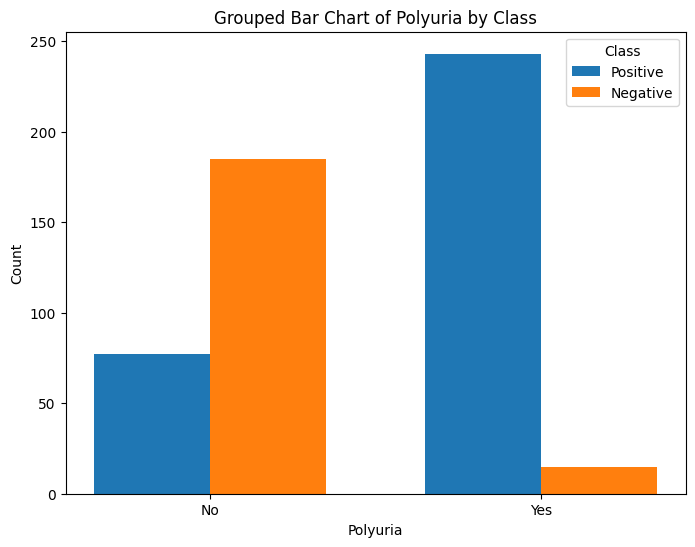

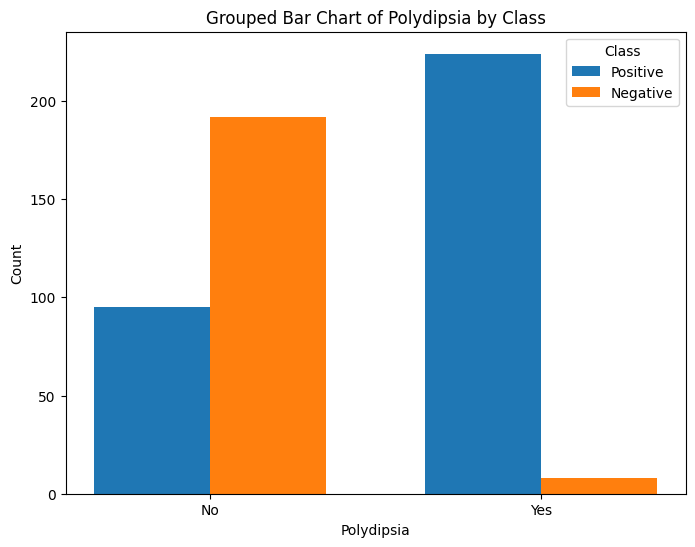

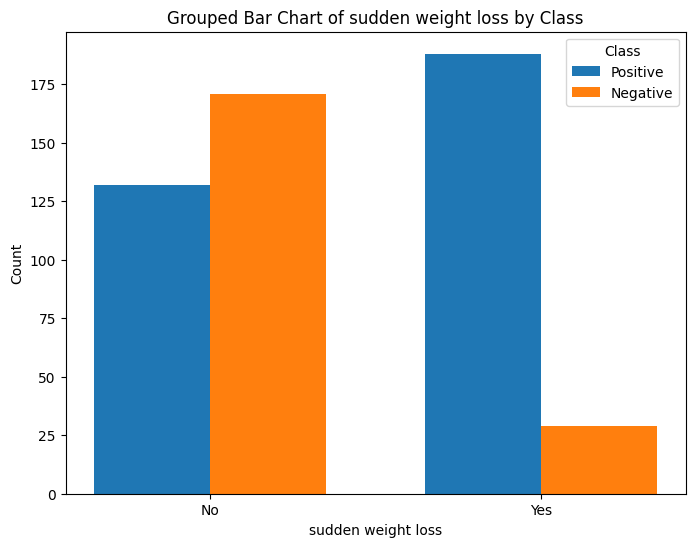

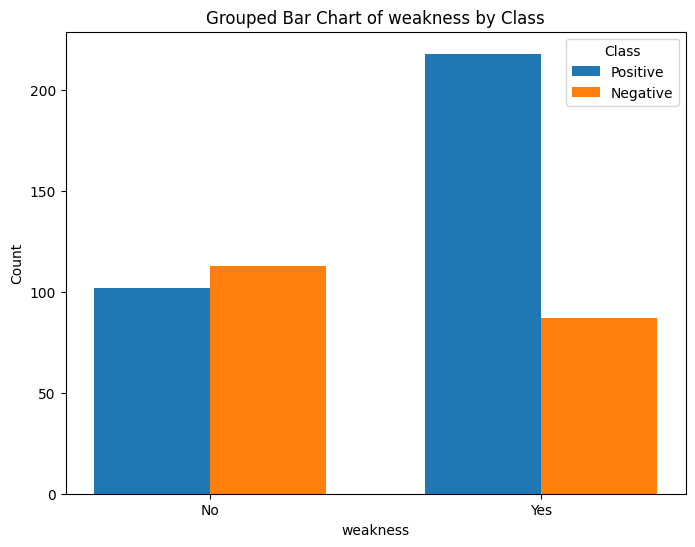

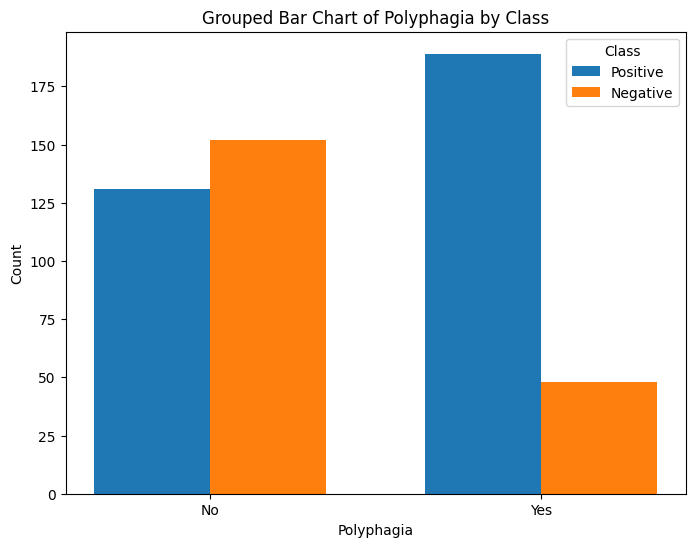

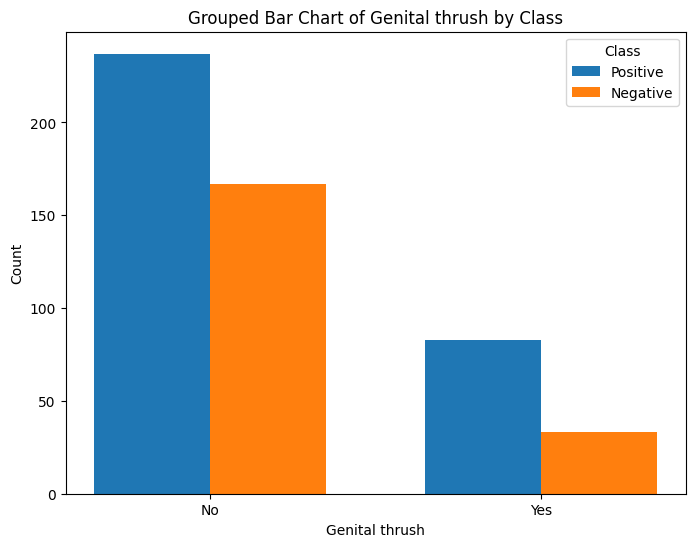

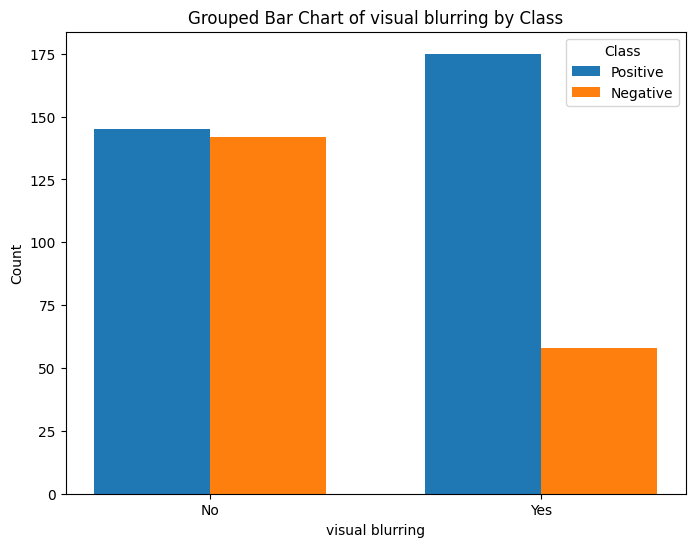

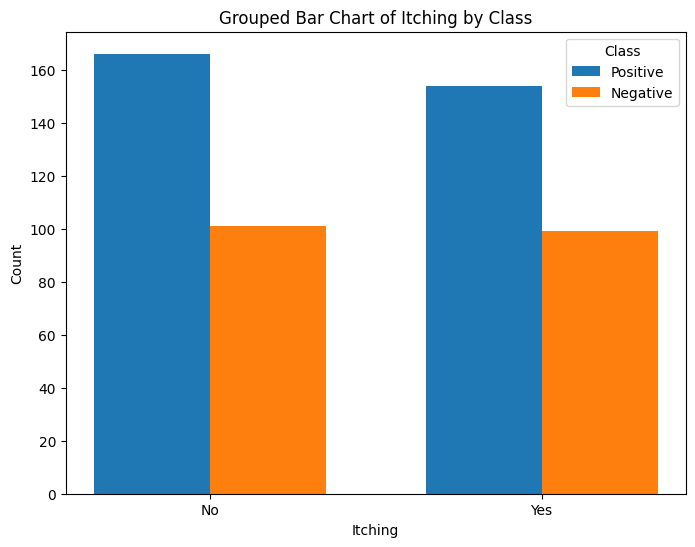

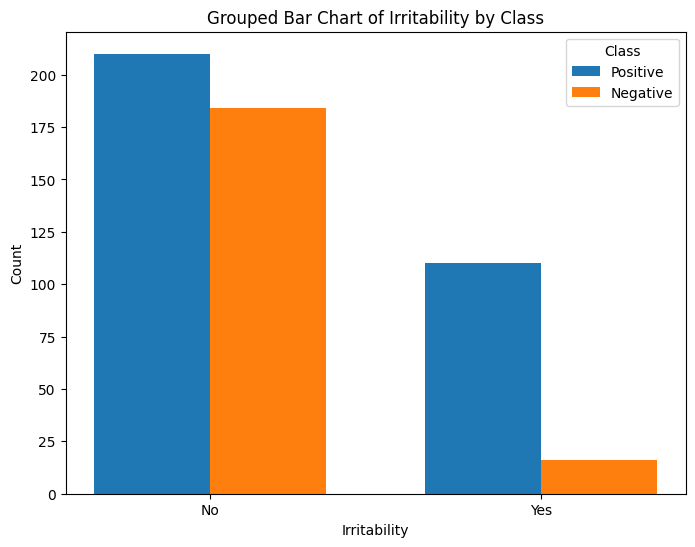

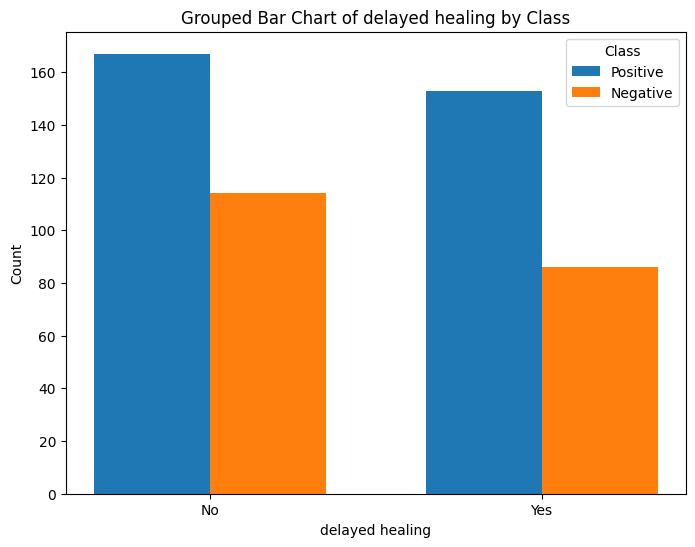

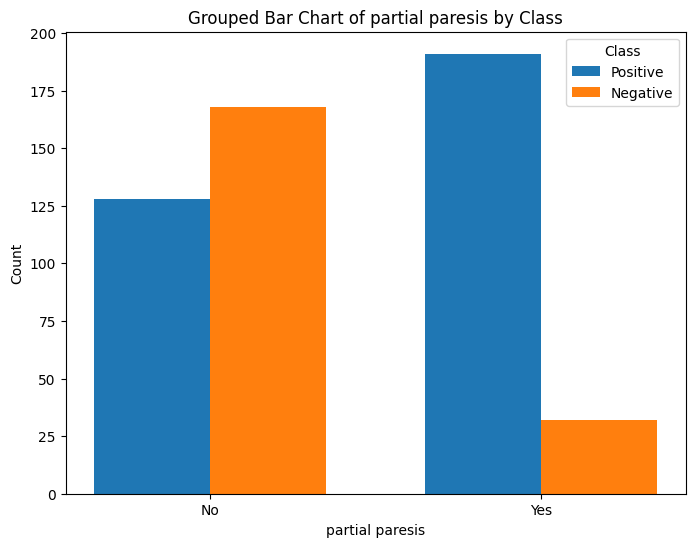

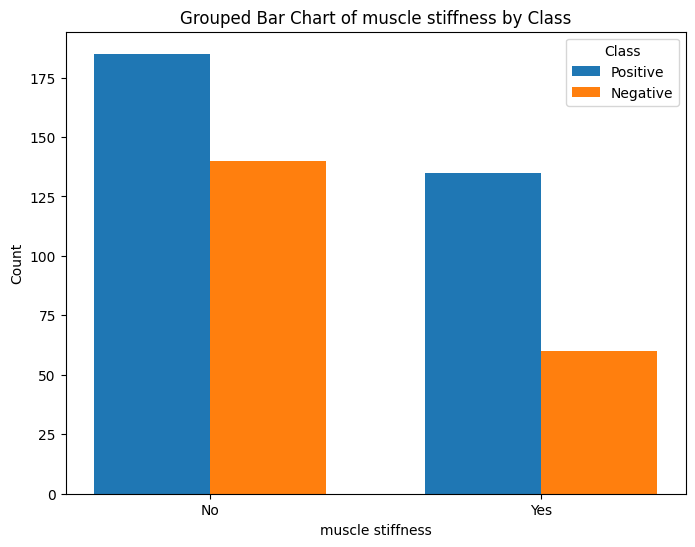

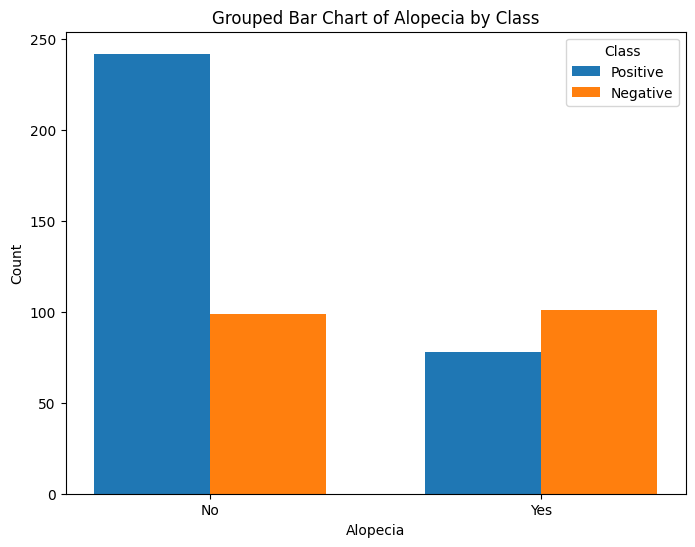

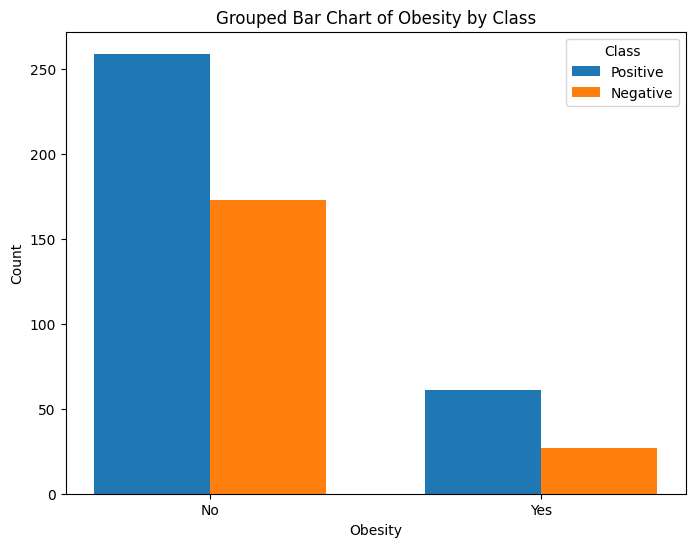

In [25]:
for feature in categorical_columns:
  feature_series = diabetes_data[feature]
  class_series = diabetes_data['class']
  create_grouped_bar_chart(feature,feature_series, class_series, feature)

In [26]:
from typing import Optional
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas.core.frame as pd_frame

def plot_correlation(data: pd_frame.DataFrame, figsize: Optional[tuple] = (12, 6)):
    """
    Create a correlation plot (heatmap) for the given DataFrame.

    Parameters:
    - data: pandas DataFrame
        The input DataFrame containing the data for which you want to plot correlations.
    - figsize: tuple, optional (default=(8, 6))
        The size of the plot (width, height) in inches.

    Returns:
    - None (displays the plot)
    """
    # Calculate the correlation matrix
    corr_matrix = data.corr()

    # Create a correlation plot (heatmap)
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Plot')
    plt.savefig('correaltionplot.png')
    plt.show()

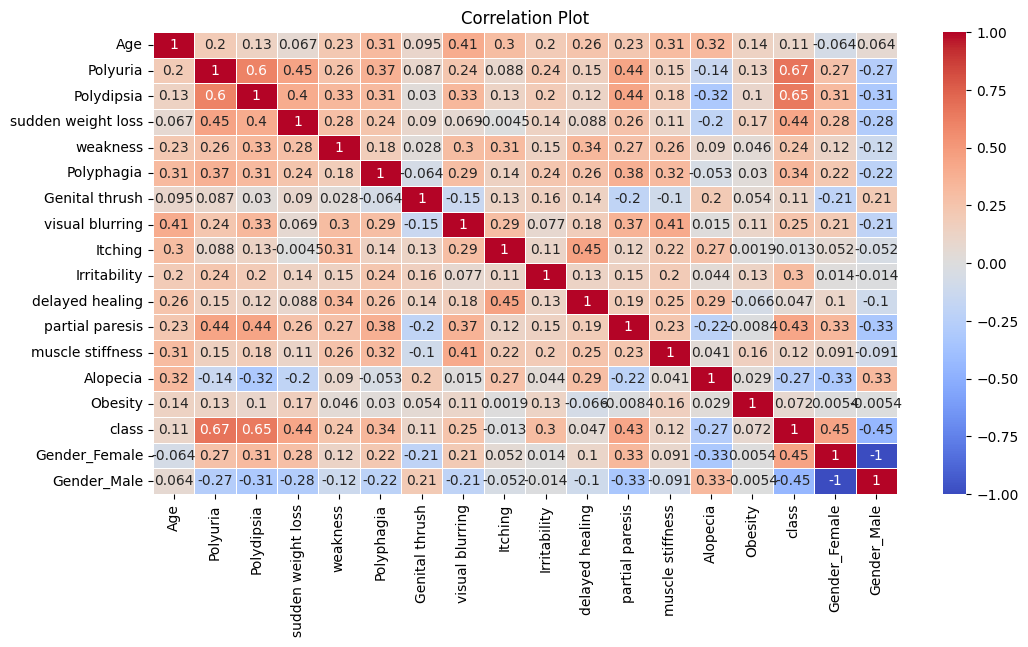

In [27]:
plot_correlation(data=diabetes_data)

## Balancing the data

In [34]:
diabetes_data['class'].value_counts()

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

def balance_data_with_oversampling(data: pd.DataFrame) -> pd.DataFrame:
    # Define the oversampling strategy using SMOTE
    oversampler = SMOTE(sampling_strategy='minority')

    # Fit and transform the data to oversample the minority class
    X_resampled, y_resampled = oversampler.fit_resample(data.drop('class', axis=1), data['class'])

    # Create a new balanced DataFrame with the oversampled data
    balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=data.columns.drop('class')), pd.Series(y_resampled, name='class')], axis=1)

    return balanced_data

def balance_data(data: pd.DataFrame) -> pd.DataFrame:

  # Define the undersampling strategy
  undersampler = RandomUnderSampler(sampling_strategy='minority')

  # Fit and transform the data to undersample the majority class
  X_resampled, y_resampled = undersampler.fit_resample(data.drop('class', axis=1), data['class'])

  # Create a new balanced DataFrame
  balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=data.columns.drop('class')), pd.Series(y_resampled, name='class')], axis=1)

  return balanced_data

balanced_data  = balance_data_with_oversampling(diabetes_data)
balanced_data['class'].value_counts()

balanced_data.to_csv('processed_diabetes_data.csv',index=False)

In [36]:
pyppeteer-install

NameError: name 'pyppeteer' is not defined